In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import struct
from scipy import signal
import pywt

%pylab inline

pwd = os.getcwd()
fb = open(pwd + "//" + "input_data" + "//" + "train1" + "//" + "140" + "//" + "1", "rb")
x = 0
data1 = []
data2 = []

interval = 5
dt = 0.0000001 * interval
fs = 10000000 / interval
start = int(250000 / interval)
end = int(350000 / interval)
fig_size = 20

while True:
    data = fb.read(4)
    if not data:
        break
    if x % interval == 0:
        ch1, ch2 = struct.unpack('<HH', data)
        ch1 = (float(ch1) - 8192) / 8192 * 2.5
        ch2 = (float(ch2) - 8192) / 8192 * 2.5
        ch1 = float(ch1)
        ch2 = float(ch2)
        data1.append(ch1)
        data2.append(ch2)
    x = x + 1

fb.close()

data1 = data1[start:end]
data2 = data2[start:end]

wavelet = 'morl'
c = pywt.central_frequency(wavelet)
fa = np.arange(400000, 20000 - 1, -20000)
scales = np.array(float(c)) * fs / np.array(fa)

[cfs1,frequencies1] = pywt.cwt(data1,scales,wavelet,dt)
[cfs2,frequencies2] = pywt.cwt(data2,scales,wavelet,dt)
power1 = (abs(cfs1)) ** 2
power2 = (abs(cfs2)) ** 2

length_now = len(power2[0])
power1 = np.reshape(power1,(len(power1),fig_size,int(length_now/fig_size)))
power2 = np.reshape(power2,(len(power2),fig_size,int(length_now/fig_size)))
power1 = np.log10(np.mean(power1,axis=2))
power2 = np.log10(np.mean(power2,axis=2))

mx = power1.max()
mn = power1.min()
power1 = (power1-mn) / (mx-mn)
power1 = power1.flatten()

mx = power2.max()
mn = power2.min()
power2 = (power2-mn) / (mx-mn)
power2 = power2.flatten()

Populating the interactive namespace from numpy and matplotlib


Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Restoring parameters from saver/SAE/SAE


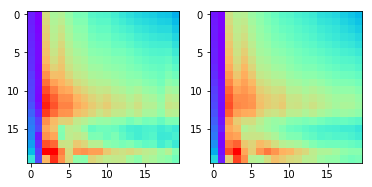

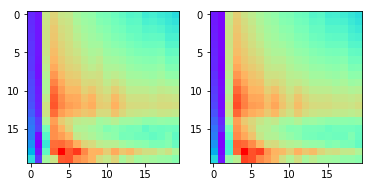

0.3617782 0.044703305


In [2]:
with tf.Session() as sess:  
    
    tf.local_variables_initializer().run()
    tf.global_variables_initializer().run()
    
    coord = tf.train.Coordinator()
    thread = tf.train.start_queue_runners(sess=sess,coord=coord)
    
    saver = tf.train.import_meta_graph('saver/SAE/SAE.meta')
    saver.restore(sess,'saver/SAE/SAE')  
    y = tf.get_collection('output_y')[0]
    l = tf.get_collection('output_y')[1]
    
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("input_x:0")
    
    outputdata1,loss1 = sess.run([y,l],feed_dict ={x:[power1]})
    outputdata2,loss2 = sess.run([y,l],feed_dict ={x:[power2]})
    
    power1 = np.reshape(power1,(20,20))
    power2 = np.reshape(power2,(20,20))
    outputdata1 = np.reshape(outputdata1,(20,20))
    outputdata2 = np.reshape(outputdata2,(20,20))
    
    
    
    plt.subplot(1,2,1)
    plt.imshow(power1,cmap=plt.get_cmap('rainbow'))
    plt.subplot(1,2,2)
    plt.imshow(outputdata1,cmap=plt.get_cmap('rainbow'))
    plt.show()
    
    plt.subplot(1,2,1)
    plt.imshow(power2,cmap=plt.get_cmap('rainbow'))
    plt.subplot(1,2,2)
    plt.imshow(outputdata2,cmap=plt.get_cmap('rainbow'))
    plt.show()
    
    print(loss1,loss2)
    
    coord.request_stop()
    coord.join(thread)